In [318]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

3 Factores controlan la intensidad de un sismos a grandes razgos:
- Magnitud
- Distancia del hipocentro
- Suelo

Peak acceleration
- How quickly the ground shook
- How swiftly it changed direction
- Built on mud substrate
  - Bay Mud
  - Allavium
  - Bedrock
Documentr that seismic waves are amplified by a facto of two as they pass from bedrock

In [319]:
df = pd.read_csv('../MACHINE_LEARNING/raw_usa.csv')

In [320]:
df.shape

(142593, 33)

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142593 entries, 0 to 142592
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   type                  142593 non-null  object 
 1   id                    142593 non-null  object 
 2   properties.mag        142593 non-null  float64
 3   properties.place      142490 non-null  object 
 4   properties.time       142593 non-null  object 
 5   properties.updated    142593 non-null  object 
 6   properties.tz         2 non-null       float64
 7   properties.url        142593 non-null  object 
 8   properties.detail     142593 non-null  object 
 9   properties.felt       23869 non-null   float64
 10  properties.cdi        23869 non-null   float64
 11  properties.mmi        6038 non-null    float64
 12  properties.alert      1235 non-null    object 
 13  properties.status     142593 non-null  object 
 14  properties.tsunami    142593 non-null  int64  
 15  

cdi y mmi, analizar que hacer con esos pocos valores.

In [322]:
df.drop(columns=['properties.cdi',	'properties.mmi'], inplace=True)

In [323]:
df.describe()

,properties.mag,properties.tz,properties.felt,properties.tsunami,properties.sig,properties.nst,properties.dmin,properties.rms,properties.gap,Longitud,Latitud,Profundidad
count,142593.000000,2.000000,23869.000000,142593.000000,142593.000000,120414.000000,93371.000000,137570.000000,133085.000000,142593.000000,142593.000000,142565.000000
mean,2.956340,-450.000000,171.115296,0.001066,142.287868,25.212974,0.231846,0.287789,114.443654,-115.053124,37.063814,6.371834
std,0.465355,42.426407,1739.291516,0.032632,69.471224,28.177695,0.328471,0.582550,81.035637,8.562332,4.143721,6.060862
min,2.120000,-480.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,-124.999667,24.602000,-3.480000
25%,2.610000,-465.000000,1.000000,0.000000,106.000000,5.000000,0.039685,0.100000,53.000000,-120.259000,34.084000,2.659000
50%,2.810000,-450.000000,4.000000,0.000000,122.000000,17.000000,0.094000,0.190000,83.500000,-117.262800,36.447167,5.511000
75%,3.130000,-435.000000,20.000000,0.000000,154.000000,36.000000,0.285600,0.340000,161.400000,-115.143167,38.824167,8.457000
max,7.300000,-420.000000,131620.000000,1.000000,2910.000000,760.000000,7.538000,69.320000,360.000000,-65.065000,49.988000,121.037000


In [324]:
df.head(1)

,type,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,...,properties.rms,properties.gap,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates,Longitud,Latitud,Profundidad
0,Feature,nc73888821,2.83,"58km WNW of Petrolia, CA",2023-05-16 16:22:09.380,2023-05-17 02:32:10.393,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,0.28,289.0,md,earthquake,"M 2.8 - 58km WNW of Petrolia, CA",Point,"[-124.9558334, 40.4253349, -0.37]",-124.955833,40.425335,-0.37


In [325]:

df.drop(['type', 'id', 'properties.place', 'properties.time',
       'properties.updated', 'properties.tz', 'properties.url',
       'properties.detail', 'properties.felt', 'properties.status',
       'properties.tsunami', 'properties.net', "properties.magType",
       'properties.code', 'properties.ids', 'properties.sources',
       'properties.nst', 'properties.dmin','properties.title',
         'geometry.type', 'geometry.coordinates', 'properties.rms',
       'Longitud', 'Latitud', 'properties.types'], axis = 1, inplace=True)

Un terremoto no puede producirse físicamente a una profundidad de 0 km o -1 km (por encima de la superficie de la Tierra). Para que se produzca un terremoto, dos bloques de corteza deben deslizarse entre sí, y es imposible que esto ocurra en la superficie terrestre o por encima de ella. Entonces, ¿por qué a veces informamos de que el seísmo se produjo a una profundidad de 0 km o de un suceso como una profundidad negativa?

En primer lugar, la profundidad de un terremoto suele ser la parte más difícil de precisar. Dado que la mayoría de los terremotos se producen a gran profundidad dentro de la corteza terrestre, un error de +/- 1 ó 2 km es irrelevante; en otras palabras, se trata de un pequeño error cuando la profundidad es algo así como 13 km. Sin embargo, si la profundidad del seísmo es relativamente baja, el problema aumenta. Una profundidad negativa puede ser a veces un artefacto de la escasa resolución para un suceso poco profundo.

En el caso de las explosiones de cantera registradas por la red sísmica, la profundidad se fija en 0 km, ya que nunca podemos determinar una profundidad precisa para ellas, pero sabemos que están muy cerca de la superficie.

A veces, debido a la densidad de la red sísmica y a la proximidad de las estaciones sísmicas al epicentro de un seísmo, podemos determinar una profundidad muy precisa. Cuando la profundidad del seísmo es muy baja, puede notificarse como profundidad negativa.

- https://www.usgs.gov/faqs/what-does-it-mean-earthquake-occurred-depth-0-km-how-can-earthquake-have-negative-depth-would

In [326]:
df['properties.type'].unique()

array(['earthquake', 'mining explosion', 'quarry blast', 'explosion',
       'mine collapse', 'experimental explosion', 'other event',
       'rock burst', 'sonic boom', 'acoustic noise', 'landslide',
       'Rock Slide', 'chemical explosion', 'nuclear explosion'],
      dtype=object)

In [327]:
df = df.loc[df['properties.type'] != 'quarry blast']

In [328]:
df.drop(columns='properties.type', inplace=True)

In [329]:
# Definir un diccionario de mapeo de valores de alerta
mapping = {"green": 1, "yellow": 2, "orange": 3, "red": 4}

# Mapear los valores al DataFrame
df["properties.alert"] = df["properties.alert"].map(mapping)
df["properties.alert"].fillna(0, inplace=True)

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139641 entries, 0 to 142592
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   properties.mag    139641 non-null  float64
 1   properties.alert  139641 non-null  float64
 2   properties.sig    139641 non-null  int64  
 3   properties.gap    130146 non-null  float64
 4   Profundidad       139613 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 6.4 MB


En sismología, la profundidad de foco, profundidad focal o profundidad del hipocentro se refiere a la profundidad a la que ocurre un terremoto. Los terremotos que ocurren a una profundidad de menos de 70 kilómetros (43,5 mi) se clasifican como terremotos de foco superficial, mientras que aquellos con una profundidad focal entre 70 kilómetros (43,5 mi) y 300 kilómetros (186,4 mi) se denominan comúnmente terremotos de foco medio o profundidad intermedia.1​ En las zonas de subducción, donde la corteza oceánica más antigua y fría desciende debajo de otra placa tectónica, pueden ocurrir terremotos de foco profundo a profundidades mucho mayores en el manto, que van desde 300 kilómetros (186,4 mi) hasta 700 kilómetros (435 mi).

In [331]:
rangos_profundida = {
    'Superficial': (0, 70),
    'Media': (70, 300),
    'Profunda': (300, 700)
}

In [332]:
df['CategoriaProfundidad'] = pd.cut(df['Profundidad'], bins=[0, 70, 300, 700], labels=['Superficial', 'Media', 'Profunda'], right=False)

In [333]:
codificacion_profundidad = pd.get_dummies(df['CategoriaProfundidad'])

In [334]:
df = pd.concat([df, codificacion_profundidad], axis=1)

In [335]:
map={True: 1, False: 0}
columnas_map = ["Superficial", "Media", "Profunda"]

for columna in columnas_map:
    df[columna] = df[columna].map(map)
    df[columna]
df.drop(columns='CategoriaProfundidad', inplace=True)

In [336]:
df.head()

,properties.mag,properties.alert,properties.sig,properties.gap,Profundidad,Superficial,Media,Profunda
0,2.83,0.0,123,289.0,-0.37,0,0,0
1,3.24,0.0,169,33.0,6.02,1,0,0
2,2.98,0.0,139,34.0,7.81,1,0,0
3,2.60,0.0,104,44.0,6.76,1,0,0
4,2.63,0.0,106,294.0,20.25,1,0,0


In [337]:
df.loc[df["properties.gap"].isna()]
#capaz relacionado con otras fuentes que no sean earthquake, fijarse
df["properties.gap"].fillna(180, inplace=True)

In [338]:
df.dropna(subset='Profundidad', inplace=True)

In [339]:
porcentajes = [(80, 20), (85, 15), (90, 10), (95, 5)]

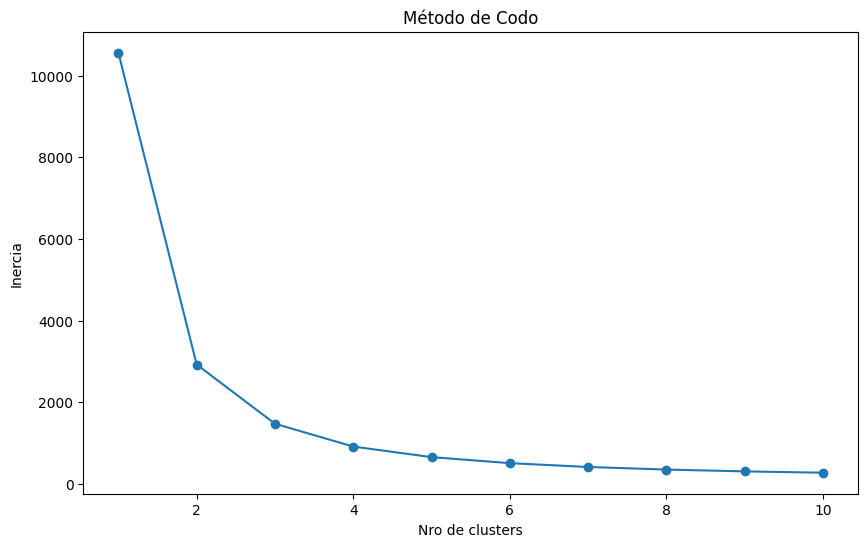

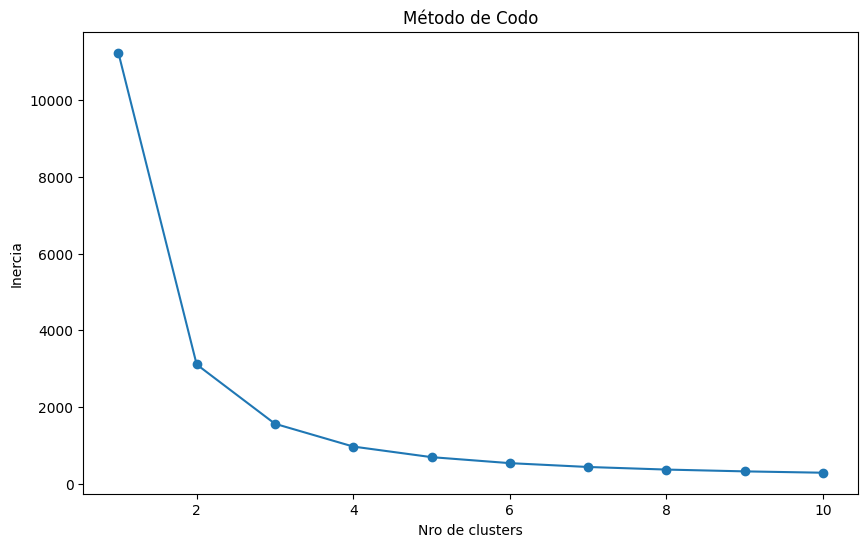

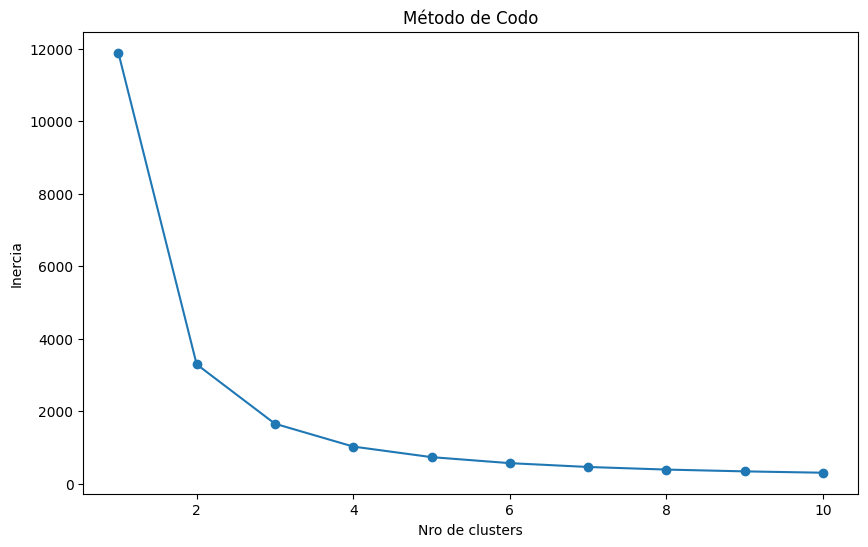

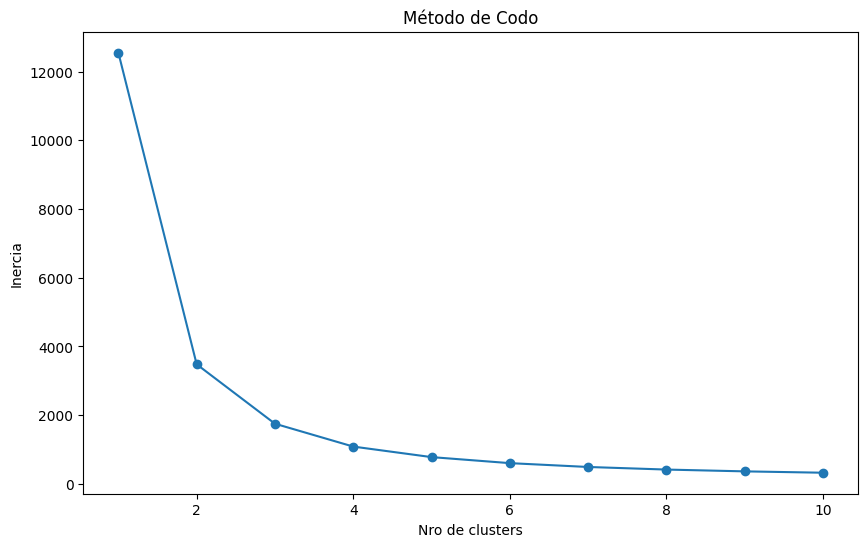

In [341]:
for porcentaje in porcentajes:
    # Obtener los porcentajes de entrenamiento y prueba
    porcentaje_entrenamiento, porcentaje_prueba = porcentaje
    
    # Calcular el tamaño del conjunto de prueba
    porcentaje_prueba = porcentaje_prueba / 100.0
    
    # Dividir el dataframe en conjuntos de entrenamiento y prueba
    X_entrenamiento, X_prueba = train_test_split(df, test_size=porcentaje_prueba, random_state=42)
    X_entrenamiento = preprocessing.Normalizer().fit_transform(X_entrenamiento)
    X_prueba = preprocessing.Normalizer().fit_transform(X_prueba)
    lista = []

    for i in range(1, 11):
        algoritmo = KMeans(n_clusters = i, init = 'k-means++',
                            max_iter = 300, n_init = 10)
        algoritmo.fit(X_entrenamiento)
        lista.append(algoritmo.inertia_)

    plt.figure(figsize = [10, 6])
    plt.title('Método de Codo')
    plt.xlabel('Nro de clusters')
    plt.ylabel('Inercia')
    plt.plot(list(range(1, 11)), lista, marker = 'o')
    plt.show()

In [342]:
algoritmo = KMeans(n_clusters = 3, init = 'k-means++', 
                   max_iter = 300, n_init = 10)

algoritmo.fit(X_entrenamiento)

KMeans(n_clusters=3, n_init=10)

In [343]:
centroides, etiquetas = algoritmo.cluster_centers_, algoritmo.labels_

muestras_prediccion = algoritmo.predict(X_prueba)

In [347]:
for i, pred in enumerate(muestras_prediccion):
  print('Muestra', i, ' Clúster:', pred)

Muestra 0  Clúster: 1
Muestra 1  Clúster: 1
Muestra 2  Clúster: 2
Muestra 3  Clúster: 0
Muestra 4  Clúster: 1
Muestra 5  Clúster: 2
Muestra 6  Clúster: 2
Muestra 7  Clúster: 0
Muestra 8  Clúster: 0
Muestra 9  Clúster: 1
Muestra 10  Clúster: 2
Muestra 11  Clúster: 1
Muestra 12  Clúster: 1
Muestra 13  Clúster: 1
Muestra 14  Clúster: 0
Muestra 15  Clúster: 2
Muestra 16  Clúster: 2
Muestra 17  Clúster: 2
Muestra 18  Clúster: 2
Muestra 19  Clúster: 1
Muestra 20  Clúster: 2
Muestra 21  Clúster: 2
Muestra 22  Clúster: 1
Muestra 23  Clúster: 1
Muestra 24  Clúster: 2
Muestra 25  Clúster: 1
Muestra 26  Clúster: 1
Muestra 27  Clúster: 1
Muestra 28  Clúster: 0
Muestra 29  Clúster: 1
Muestra 30  Clúster: 0
Muestra 31  Clúster: 1
Muestra 32  Clúster: 2
Muestra 33  Clúster: 2
Muestra 34  Clúster: 0
Muestra 35  Clúster: 2
Muestra 36  Clúster: 1
Muestra 37  Clúster: 0
Muestra 38  Clúster: 0
Muestra 39  Clúster: 1
Muestra 40  Clúster: 1
Muestra 41  Clúster: 2
Muestra 42  Clúster: 2
Muestra 43  Clúster: 

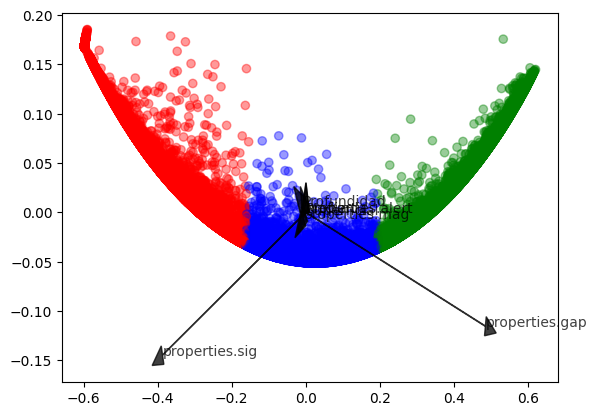

In [345]:
modelo_pca = PCA(n_components = 2)
modelo_pca.fit(X_entrenamiento)
pca = modelo_pca.transform(X_entrenamiento) 

centroides_pca = modelo_pca.transform(centroides)

colores = ['blue', 'red', 'green']

colores_cluster = [colores[etiquetas[i]] for i in range(len(pca))]

plt.scatter(pca[:, 0], pca[:, 1], c = colores_cluster, 
            marker = 'o',alpha = 0.4)

plt.scatter(centroides_pca[:, 0], centroides_pca[:, 1],
            marker = 'x', s = 100, linewidths = 3, c = colores)

xvector = modelo_pca.components_[0] * max(pca[:,0])
yvector = modelo_pca.components_[1] * max(pca[:,1])
columnas = df.columns

for i in range(len(columnas)):
    #Se grafican los vectores
    plt.arrow(0, 0, xvector[i], yvector[i], color = 'black', 
              width = 0.0005, head_width = 0.02, alpha = 0.75)
    plt.text(xvector[i], yvector[i], list(columnas)[i], color='black', 
             alpha=0.75)

plt.show()